In [1]:
import os
import io
import tqdm
import detectron2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import some common libraries
import numpy as np
import cv2
import torch

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# Load VG Classes
data_path = '/scratch/gobi1/johnchen/new_git_stuff/py-bottom-up-attention/data'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())
        
vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())


MetadataCatalog.get("vg").thing_classes = vg_classes
MetadataCatalog.get("vg").attr_classes = vg_attrs

In [3]:
cfg = get_cfg()
cfg.merge_from_file("../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
# VG Weight
cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl"
predictor = DefaultPredictor(cfg)

Config '../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401



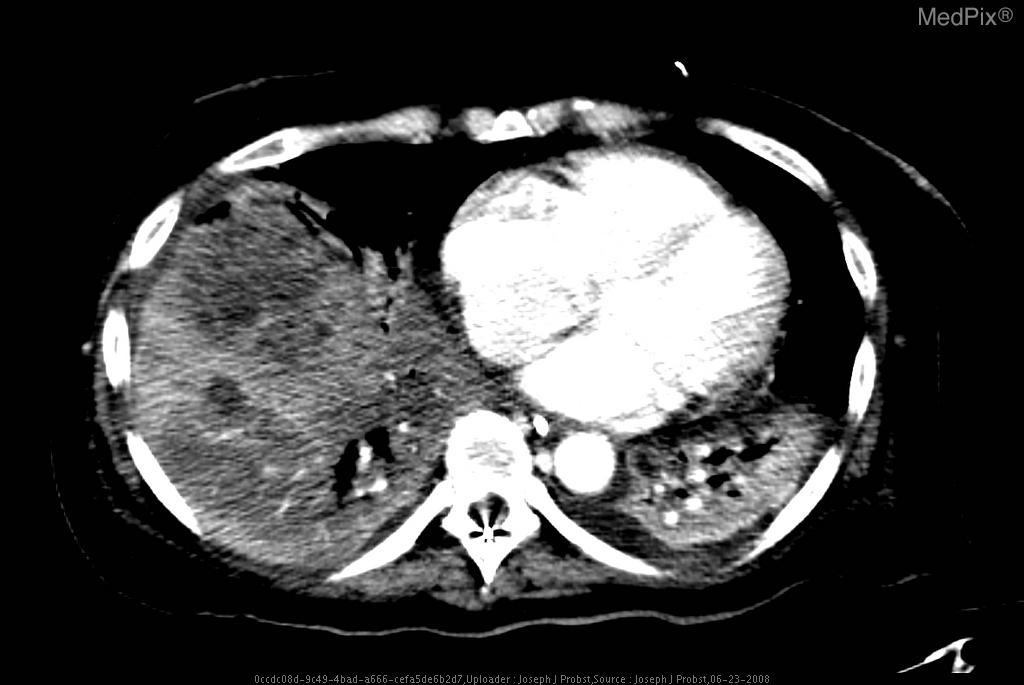

In [4]:
import os
from tqdm.auto import tqdm
images_path = "/scratch/gobi1/johnchen/new_git_stuff/lxmert/data/medvqa/VQA-Med-2020-Task1-VQAnswering-TrainVal-Sets/VQAMed2020-VQAnswering-TrainingSet/VQAnswering_2020_Train_images"
all_imgs = []
def process_images():
    
    for root,dirs,files in os.walk(images_path):
        for file in tqdm(files):
            im = cv2.imread(os.path.join(root,file))
            im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            all_imgs.append(im_rgb)
#             showarray(im_rgb)

process_images()
# im = cv2.imread("/scratch/gobi1/johnchen/new_git_stuff/py-bottom-up-attention/data/synpic593.jpg")
# im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
showarray(all_imgs[-1])

In [12]:
NUM_OBJECTS = 36

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image

def doit(raw_image):
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
        print("Original image size: ", (raw_height, raw_width))
        
        # Preprocessing
        image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
        print("Transformed image size: ", image.shape[:2])
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)
        
        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)
        
        # Generate proposals with RPN
        proposals, _ = predictor.model.proposal_generator(images, features, None)
        proposal = proposals[0]
        print('Proposal Boxes size:', proposal.proposal_boxes.tensor.shape)
        
        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [x.proposal_boxes for x in proposals]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
        print('Pooled features size:', feature_pooled.shape)
        
        # Predict classes and boxes for each proposal.
        pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        outputs = FastRCNNOutputs(
            predictor.model.roi_heads.box2box_transform,
            pred_class_logits,
            pred_proposal_deltas,
            proposals,
            predictor.model.roi_heads.smooth_l1_beta,
        )
        probs = outputs.predict_probs()[0]
        boxes = outputs.predict_boxes()[0]
        
        attr_prob = pred_attr_logits[..., :-1].softmax(-1)
        max_attr_prob, max_attr_label = attr_prob.max(-1)
        
        # Note: BUTD uses raw RoI predictions,
        #       we use the predicted boxes instead.
        # boxes = proposal_boxes[0].tensor    
        
        # NMS
        for nms_thresh in np.arange(0.5, 1.0, 0.1):
            instances, ids = fast_rcnn_inference_single_image(
                boxes, probs, image.shape[1:], 
                score_thresh=0.2, nms_thresh=nms_thresh, topk_per_image=NUM_OBJECTS
            )
            if len(ids) == NUM_OBJECTS:
                break
                
        instances = detector_postprocess(instances, raw_height, raw_width)
        roi_features = feature_pooled[ids].detach()
        max_attr_prob = max_attr_prob[ids].detach()
        max_attr_label = max_attr_label[ids].detach()
        instances.attr_scores = max_attr_prob
        instances.attr_classes = max_attr_label
        
        print(instances)
        
        return instances, roi_features

# all_features = []
# for cv2_img in tqdm(all_imgs):
#     instances, features = doit(cv2_img)
#     all_features.append((instances,features))
instances, features = doit(all_imgs[-1])

# print(instances.pred_boxes)
# print(instances.scores)
# print(instances.pred_classes)
# print(instances.attr_classes)
# print(instances.attr_scores)



Original image size:  (685, 1024)
Transformed image size:  (800, 1196)
Proposal Boxes size: torch.Size([107, 4])
Pooled features size: torch.Size([107, 2048])
Instances(num_instances=26, image_height=685, image_width=1024, fields=[pred_boxes, scores, pred_classes, attr_scores, attr_classes])


In [19]:
instances.attr_classes

tensor([ 11,  11,   7, 163,   7,   7,   7, 163,  11, 163,   7,  11, 163,   7,
          7,   7,   7,   7,  11,   7,   7, 163,   7,   7,  11,   7],
       device='cuda:0')

In [27]:
(instances.pred_boxes)

Boxes(tensor([[2.2778e+02, 1.3005e+02, 5.3285e+02, 2.9880e+02],
        [2.2738e+02, 9.9733e+01, 5.6675e+02, 2.8024e+02],
        [4.3529e+02, 8.8691e+00, 9.5445e+02, 4.2413e+02],
        [1.2483e+00, 1.9482e+00, 7.3195e+02, 2.4749e+02],
        [3.8193e+02, 3.1409e+01, 8.6606e+02, 4.6317e+02],
        [1.7067e+02, 8.4857e+01, 5.4752e+02, 2.6166e+02],
        [4.1901e+02, 1.2294e+02, 9.0890e+02, 5.4064e+02],
        [4.8942e-01, 1.8325e+00, 5.7993e+02, 2.2042e+02],
        [0.0000e+00, 2.0419e+00, 4.0364e+02, 3.5917e+02],
        [0.0000e+00, 1.1431e+00, 4.7678e+02, 2.8606e+02],
        [2.5373e+02, 5.2835e+01, 9.7608e+02, 4.5294e+02],
        [2.7456e+02, 1.0568e+02, 5.2482e+02, 2.8500e+02],
        [1.0370e+02, 2.7992e+00, 8.9314e+02, 2.5076e+02],
        [4.9485e+02, 4.4994e+01, 1.0213e+03, 4.3988e+02],
        [3.6639e+02, 1.2751e+02, 8.2658e+02, 5.2072e+02],
        [3.8502e+02, 4.8876e+01, 1.0240e+03, 5.1301e+02],
        [3.2656e+02, 6.5756e+01, 8.1299e+02, 4.7967e+02],
        

In [26]:
instances.pred_boxes.tensor

tensor([[2.2778e+02, 1.3005e+02, 5.3285e+02, 2.9880e+02],
        [2.2738e+02, 9.9733e+01, 5.6675e+02, 2.8024e+02],
        [4.3529e+02, 8.8691e+00, 9.5445e+02, 4.2413e+02],
        [1.2483e+00, 1.9482e+00, 7.3195e+02, 2.4749e+02],
        [3.8193e+02, 3.1409e+01, 8.6606e+02, 4.6317e+02],
        [1.7067e+02, 8.4857e+01, 5.4752e+02, 2.6166e+02],
        [4.1901e+02, 1.2294e+02, 9.0890e+02, 5.4064e+02],
        [4.8942e-01, 1.8325e+00, 5.7993e+02, 2.2042e+02],
        [0.0000e+00, 2.0419e+00, 4.0364e+02, 3.5917e+02],
        [0.0000e+00, 1.1431e+00, 4.7678e+02, 2.8606e+02],
        [2.5373e+02, 5.2835e+01, 9.7608e+02, 4.5294e+02],
        [2.7456e+02, 1.0568e+02, 5.2482e+02, 2.8500e+02],
        [1.0370e+02, 2.7992e+00, 8.9314e+02, 2.5076e+02],
        [4.9485e+02, 4.4994e+01, 1.0213e+03, 4.3988e+02],
        [3.6639e+02, 1.2751e+02, 8.2658e+02, 5.2072e+02],
        [3.8502e+02, 4.8876e+01, 1.0240e+03, 5.1301e+02],
        [3.2656e+02, 6.5756e+01, 8.1299e+02, 4.7967e+02],
        [3.393

In [30]:
instances.pred_boxes.tensor.cpu().numpy().shape

(26, 4)

In [31]:
instances.attr_scores.cpu().numpy().shape

(26,)

In [16]:
import pandas

In [18]:
df = pandas.DataFrame()

In [28]:
df["objects_id"] = instances.pred_classes.cpu().numpy()
df["objects_conf"] = instances.scores.cpu().numpy()

df["attrs_id"] = instances.attr_classes.cpu().numpy()

df["attrs_scores"] = instances.attr_scores.cpu().numpy()

df["boxes"] = instances.pred_boxes.tensor.cpu().numpy()

df["features"] = features.cpu().numpy()


ValueError: Wrong number of items passed 4, placement implies 1

In [ ]:
# Show the boxes, labels, and features
pred = instances.to('cpu')
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])
print('instances:\n', instances)
print()
print('boxes:\n', instances.pred_boxes)
print()
print('Shape of features:\n', features.shape)

In [ ]:
# Verify the correspondence of RoI features
pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(features)
pred_class_probs = torch.nn.functional.softmax(pred_class_logits, -1)[:, :-1]
max_probs, max_classes = pred_class_probs.max(-1)
print("%d objects are different, it is because the classes-aware NMS process" % (NUM_OBJECTS - torch.eq(instances.pred_classes, max_classes).sum().item()))
print("The total difference of score is %0.4f" % (instances.scores - max_probs).abs().sum().item())